<a href="http://landlab.github.io"><img style="float: left; height: 175px; width: 175px" src="../landlab_logo_picture.jpg"></a> <h3 style="margin: 117px 0 0 185px; font-weight: 300;">a toolkit for modeling earth surface processes</h3>

# How to write a Landlab component

<hr>
<small> For instructions on how to run an interactive iPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/release/README.md">https://github.com/landlab/tutorials/blob/release/README.md</a></small><br>
<small>For the unexpanded version to download and run, click here: <a href="http://nbviewer.jupyter.org/github/landlab/tutorials/blob/release/making_components/making_components_unexpanded.ipynb">http://nbviewer.jupyter.org/github/landlab/tutorials/blob/release/making_components/making_components_unexpanded.ipynb</a></small><br>
<small>For more Landlab tutorials, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

This ipython notebook walks you through the basic procedure for writing a Landlab component, using the example of a kinematic-wave flow model.

## Overview
A Landlab component is implemented as a Python `class`. Although every Landlab component is unique in some respects, to be a component, a class must have at least the following standard ingredients:

(1) The class must inherit the base class `Component`.

(2) The class must include a set of standard variables defined in the header (i.e., before the `__init__` method), which describe the data arrays that the component uses.

(3) The class must have an `__init__` method defined, with a semi-standardized parameter list described below.

(4) The class must provide a function that does performs the component's "action", typically named `run_one_step()` and this function's parameter list must follow the convention described below.


## Class definition and header

A Landlab component is a class that inherits from `Component`. The name of the class should be in CamelCase, and should make sense when used in the sentence: "A *(component-name)* is a...". The class definition should be followed by a docstring. The docstring should include a list of parameters for the `__init__` method and succintly describe them.

In [1]:
from landlab import Component, FieldError
import numpy as np

class KinwaveOverlandFlowModel(Component):
    """
    Calculate water flow over topography.
    
    Landlab component that implements a two-dimensional 
    kinematic wave model.
    
    Construction:
    
        KinwaveOverlandFlowModel(grid, precip_rate=1.0,
                                 precip_duration=1.0,
                                 infilt_rate=0.0,
                                 roughness=0.01, **kwds)
    
    Parameters
    ----------
    grid : ModelGrid
        A Landlab grid object.
    precip_rate : float, optional (defaults to 1 mm/hr)
        Precipitation rate, mm/hr
    precip_duration : float, optional (defaults to 1 hour)
        Duration of precipitation, hours
    infilt_rate : float, optional (defaults to 0)
        Maximum rate of infiltration, mm/hr
    roughnes : float, defaults to 0.01
        Manning roughness coefficient, s/m^1/3

    """
    def __init__(): # ignore this for now, we will add more stuff eventually. 
        pass 

## Doc tests

The following section 'Examples' should help the user understand what is the component's purpose and how it works. It is an example (or examples) of its use in a (more or less) simple case within the Landlab framework: a grid is created, the component is instantiated on this grid and run. Unlike in the example below, we strongly recommend commenting your example(s) to explain what is happening.
This is also the section that will be run during the integration tests of your component (once you submitted a pull request to have your component merged into the Landlab release branch). All lines starting with >>> are run and should produce the results you provided: here, the test fail if `kw.vel_coeff` does not return `100.0.`

In [2]:
    """
    Examples
    --------
    >>> from landlab import RasterModelGrid
    >>> rg = RasterModelGrid((4, 5), 10.0)
    >>> kw = KinwaveOverlandFlowModel(rg)
    >>> kw.vel_coef
    100.0
    >>> rg.at_node['surface_water__depth']
    array([ 0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.])
    """

"\nExamples\n--------\n>>> from landlab import RasterModelGrid\n>>> rg = RasterModelGrid((4, 5), 10.0)\n>>> kw = KinwaveOverlandFlowModel(rg)\n>>> kw.vel_coef\n100.0\n>>> rg.at_node['surface_water__depth']\narray([ 0.,  0.,  0.,  0.,  0.,\n        0.,  0.,  0.,  0.,  0.,\n        0.,  0.,  0.,  0.,  0.,\n        0.,  0.,  0.,  0.,  0.])\n"

### Header information: `_name`
Every component should have a name, as a string. Normally this will be the same as the class name.

In [3]:
_name = 'KinwaveOverlandFlowModel'

### Header information: `_input_var_names`
"Input variables" here refers to those arrays (fields) that the component needs, and for which initial values must be specified. In our kinematic wave example, we need topography. We'll take elevation, and calculate slope. Therefore, elevation will be an input variable, and slope an output (though we won't modify it). A more advanced model might also need spatially variable precipitation, infiltration capacity, and/or roughness, but here we'll treat these as uniform.

The `_input_var_names` should be a tuple of strings. These strings give the formal names for the fields, and should use standard Landlab semantics. In brief, Landlab's naming scheme follows the pattern of the CSDMS standard names, with the quantity at the end of the string, and any descriptors beforehand, separated from the quantity by two underscores.

In [4]:
_input_var_names = (
    'topographic__elevation',
)

### Header information: `_output_var_names`
*Output variables* are those arrays (fields) that the component solves for as part of its normal operation. In our kinematic wave example, the component will create fields for topographic gradient, water depth, velocity, and discharge per unit width (a.k.a., specific discharge).

Like `_input_var_names`, `_output_var_names` should be either a tuple of strings with names based on <a href="https://github.com/landlab/landlab/wiki/Components#landlab-standard-naming-conventions">standard Landlab semantics</a> .

In [5]:
_output_var_names = (
    'topographic__gradient', 
    'surface_water__depth',
    'water__velocity',
    'water__specific_discharge',
)

### Header information: `_var_units`
This is a dictionary that defines the units of each variable (both input and output).

In [6]:
_var_units = {
    'topographic__elevation': 'm',
    'topographic__gradient': 'm/m',
    'surface_water__depth': 'm',
    'water__velocity': 'm/s',
    'water__specific_discharge': 'm2/s',
}

### Header information: `_var_mapping`
This is a dictionary that describes the grid element to which each field is mapped. In our example, elevation and water depth (both scalars) are mapped to nodes, whereas velocity and discharge (both vectors) are mapped to links.

In [7]:
_var_mapping = {
    'topographic__elevation': 'node',
    'topographic__gradient': 'link',
    'surface_water__depth': 'node',
    'water__velocity': 'link',
    'water__specific_discharge': 'link',
}

### Header information: `_var_doc`
This final piece of header data provides information about what each variable represents, encoded as a dictionary in which the keys are the field names and values are the descriptions, as strings.

In [8]:
_var_doc = {
    'topographic__elevation':
        'elevation of the ground surface relative to some datum',
    'topographic__gradient':
        'gradient of the ground surface',
    'surface_water__depth':
        'depth of water',
    'water__velocity':
        'flow velocity component in the direction of the link',
    'water__specific_discharge':
        'flow discharge component in the direction of the link',    
}

### Class with complete header information

In [9]:
from landlab import Component, FieldError
import numpy as np

class KinwaveOverlandFlowModel(Component):
    """
    Calculate water flow over topography.
    
    Landlab component that implements a two-dimensional 
    kinematic wave model.
    
    Construction:
    
        KinwaveOverlandFlowModel(grid, [stuff to be added later])
    
    Parameters
    ----------
    grid : ModelGrid
        A Landlab grid object.
    [others to be added later]
    """

    _name = 'KinwaveOverlandFlowModel'

    _input_var_names = (
        'topographic__elevation',
    )

    _output_var_names = (
        'topographic__gradient',
        'surface_water__depth',
        'water__velocity',
        'water__specific_discharge',
    )

    _var_units = {
        'topographic__elevation': 'm',
        'topographic__gradient': 'm/m',
        'surface_water__depth': 'm',
        'water__velocity': 'm/s',
        'water__specific_discharge': 'm2/s',
    }
    
    _var_mapping = {
        'topographic__elevation': 'node',
        'topographic__gradient': 'link',
        'surface_water__depth': 'node',
        'water__velocity': 'link',
        'water__specific_discharge': 'link',
    }

    _var_doc = {
        'topographic__elevation':
            'elevation of the ground surface relative to some datum',
        'topographic__gradient':
            'gradient of the ground surface',
        'surface_water__depth':
            'depth of water',
        'water__velocity':
            'flow velocity component in the direction of the link',
        'water__specific_discharge':
            'flow discharge component in the direction of the link',    
    }
    def __init__(): # ignore this for now, we will add more stuff eventually. 
        pass

## The initialization method (`__init__`)
Every Landlab component should have an `__init__` method. The parameter signature should start with a `ModelGrid` object as the first parameter, and list `**kwds` as the last parameter. In between are component-specific parameters. In our example, the parameters for the kinematic wave model include: precipiation rate, precipitation duration, infiltration rate, and roughness coefficient (Manning's n). (The final `**kwds` is what allows you to pass in a dictionary of input parameters, so make sure it's there).

Two things a component `__init__` method common does are (1) store the component's parameters as class attributes, and (2) create the necessary fields. When creating grid fields, it is important to first check to see whether a field with the same name (and mapping) already exists. For example, a driver or another component might have already created `topographic__elevation` when our kinematic wave component is initialized.

There are a couple of different approaches to creating and working with fields. In the example below, we use the straightforward approach of creating them one at a time by name. We keep a reference to each field as a variable; for example, `self.elev` refers to the grid field `topographic_elevation`. It is also possible to automate the process by looping over all names in, say, `_var_mapping`, checking each to see whether it exists, and creating it if not. The `Component` method `initialize_output_fields()` may help with this, which will already be a member of your component because it inherits from `Component`.

In [10]:
def __init__(self, grid, precip_rate=1.0, precip_duration=1.0, 
             infilt_rate=0.0, roughness=0.01, **kwds):
    """Initialize the KinwaveOverlandFlowModel.
    
    Parameters
    ----------
    grid : ModelGrid
        Landlab ModelGrid object
    precip_rate : float, optional (defaults to 1 mm/hr)
        Precipitation rate, mm/hr
    precip_duration : float, optional (defaults to 1 hour)
        Duration of precipitation, hours
    infilt_rate : float, optional (defaults to 0)
        Maximum rate of infiltration, mm/hr
    roughness : float, defaults to 0.01
        Manning roughness coefficient, s/m^1/3
    """

    # Store grid and parameters and do unit conversion
    self._grid = grid
    self.precip = precip_rate / 3600000.0 # convert to m/s
    self.precip_duration = precip_duration * 3600.0  # convert to s
    self.infilt = infilt_rate / 3600000.0 # convert to m/s
    self.vel_coef = 1.0 / roughness  # do division now to save time

    # Create fields...
    #   Elevation
    if 'topographic__elevation' in grid.at_node:
        self.elev = grid.at_node['topographic__elevation']
    else:
        raise FieldError(
            'A topography is required as a component input!')
    #   Slope
    if 'topographic__gradient' in grid.at_link:
        self.slope = grid.at_link['topographic__gradient']
    else:
        self.slope = grid.add_zeros('link', 'topographic__gradient')
        # this field is "nice to have", but we build it if necessary
    #  Water depth
    if 'surface_water__depth' in grid.at_node:
        self.depth = grid.at_node['surface_water__depth']
    else:
        self.depth = grid.add_zeros('node', 'surface_water__depth')
    #  Velocity
    if 'water__velocity' in grid.at_link:
        self.vel = grid.at_link['water__velocity']
    else:
        self.vel = grid.add_zeros('link', 'water__velocity')
    #  Discharge
    if 'water__specific_discharge' in grid.at_link:
        self.disch = grid.at_link['water__specific_discharge']
    else:
        self.disch = grid.add_zeros('link',
                                    'water__specific_discharge')

    # Calculate the ground-surface slope (assume it won't change)
    self.slope[self._grid.active_links] = \
        self._grid.calc_grad_at_link(self.elev)[self._grid.active_links]
    self.sqrt_slope = np.sqrt( self.slope )

## The "go" method, `run_one_step()`
Every Landlab component will have a method that implements the component's action. The go method can have any name you like, but the preferred practice is to use the standard name `run_one_step()`. Landlab assumes that if a component has a method with this name, it will a. be the primary "go" method, and b. will be fully standardized as described here.

The first argument in the function signature should always be a duration to run, `dt`; i.e., a timestep length. If the component does not evolve as time passes, this argument may be missing (see, e.g., the FlowRouter, which returns a steady state flow pattern independent of time).

The remainder of the parameters are specific to the component. In this case, the component-specific parameter is the current simulation time, which determines whether it's still raining.

The first step in the algorithm is to calculate water depth *at the links*, where we will be calculating the water discharge. In this particular case, we'll use the depth at the upslope of the two nodes. The grid method to do this, `map_value_at_max_node_to_link`, is one of many mapping functions available.

We then calculate velocity using the Manning equation, and specific discharge by multiplying velocity by depth.

Mass balance for the cells around nodes is computed using the `calc_flux_div_at_node` grid method.

In [11]:
    def run_one_step(self, dt, current_time=0.0, **kwds):
        """Calculate water flow for a time period `dt`.
        """
        # Calculate water depth at links.
        H_link = self.grid.map_value_at_max_node_to_link(
                'topographic__elevation', 'surface_water__depth')

        # Calculate velocity
        self.vel = self.vel_coef * H_link**0.66667 * self.sqrt_slope

        # Calculate discharge
        self.disch = H_link * self.vel

        # Flux divergence
        dqda = self.grid.calc_flux_div_at_node(self.disch)

        # Rate of change of water depth
        if current_time < self.precip_duration:
            ppt = self.precip
        else:
            ppt = 0.0
        dHdt = ppt - self.infilt - dqda

        # Update water depth
        self.depth[self.grid.core_nodes] += dHdt[self.grid.core_nodes] * dt

        # Somewhat crude numerical hack: prevent negative water depth
        self.depth[np.where(self.depth < 0.0)[0]] = 0.0

## Changes to boundary conditions

Sometimes, as in this example, it proves convenient to hard-code assumptions about boundary conditions into the `__init__` method. In this case, note that the final two lines of `__init__` invoke `grid.active_links` - so if the boundary conditions are updated after we initialize, it's possible `self.depth` will not be correct.

We can resolve this issue by creating an additional component method that updates these components that can be called if the boundary conditions change. Whether the boundary conditions have changed can be assessed with a grid method called `bc_set_code`. This is an `int` which will change if the boundary conditions change.

In [12]:
    def __init__(self, grid, precip_rate=1.0, precip_duration=1.0, 
             infilt_rate=0.0, roughness=0.01, **kwds):
        """Initialize the KinwaveOverlandFlowModel.
        ...
        """
        # Store grid and parameters and do unit conversion
        self._grid = grid
        self._bc_set_code = self.grid.bc_set_code
        # ...

    def updated_boundary_conditions(self):
        """Call if boundary conditions are updated.
        """
        # Calculate the ground-surface slope (assume it won't change)
        self.slope[self.grid.active_links] = \
            self.grid.calc_grad_at_link(self.elev)[self.grid.active_links]
        self.sqrt_slope = np.sqrt(self.slope)


    def run_one_step(self, dt, current_time=0.0, **kwds):
        """Calculate water flow for a time period `dt`.
        """
        if self._bc_set_code != self.grid.bc_set_code:
            self.updated_boundary_conditions()
            self._bc_set_code = self.grid.bc_set_code
        # Calculate water depth at links.
        # ...

## The complete component

In [13]:
from landlab import Component, FieldError
import numpy as np

class KinwaveOverlandFlowModel(Component):
    """
    Calculate water flow over topography.
    
    Landlab component that implements a two-dimensional 
    kinematic wave model.
    
    Construction:
    
        KinwaveOverlandFlowModel(grid, precip_rate=1.0, 
                                 precip_duration=1.0, 
                                 infilt_rate=0.0,
                                 roughness=0.01, **kwds)
    
    Parameters
    ----------
    grid : ModelGrid
        A Landlab grid object.
    precip_rate : float, optional (defaults to 1 mm/hr)
        Precipitation rate, mm/hr
    precip_duration : float, optional (defaults to 1 hour)
        Duration of precipitation, hours
    infilt_rate : float, optional (defaults to 0)
        Maximum rate of infiltration, mm/hr
    roughnes : float, defaults to 0.01
        Manning roughness coefficient, s/m^1/3
        
    Examples
    --------
    >>> from landlab import RasterModelGrid
    >>> rg = RasterModelGrid((4, 5), 10.0)
    >>> kw = KinwaveOverlandFlowModel(rg)
    >>> kw.vel_coef
    100.0
    >>> rg.at_node['surface_water__depth']
    array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,  0.,  0.])    
    """

    _name = 'KinwaveOverlandFlowModel'

    _input_var_names = (
        'topographic__elevation',
    )

    _output_var_names = (
        'topographic__gradient',
        'surface_water__depth',
        'water__velocity',
        'water__specific_discharge',
    )

    _var_units = {
        'topographic__elevation' : 'm',
        'topographic__slope' : 'm/m',
        'surface_water__depth' : 'm',
        'water__velocity' : 'm/s',
        'water__specific_discharge' : 'm2/s',
    }

    _var_mapping = {
        'topographic__elevation' : 'node',
        'topographic__gradient' : 'link',
        'surface_water__depth' : 'node',
        'water__velocity' : 'link',
        'water__specific_discharge' : 'link',
    }

    _var_doc = {
        'topographic__elevation':
            'elevation of the ground surface relative to some datum',
        'topographic__gradient':
            'gradient of the ground surface',
        'surface_water__depth':
            'depth of water',
        'water__velocity':
            'flow velocity component in the direction of the link',
        'water__specific_discharge':
            'flow discharge component in the direction of the link',    
    }

    def __init__(self, grid, precip_rate=1.0, precip_duration=1.0, 
                 infilt_rate=0.0, roughness=0.01, **kwds):
        """Initialize the KinwaveOverlandFlowModel.

        Parameters
        ----------
        grid : ModelGrid
            Landlab ModelGrid object
        precip_rate : float, optional (defaults to 1 mm/hr)
            Precipitation rate, mm/hr
        precip_duration : float, optional (defaults to 1 hour)
            Duration of precipitation, hours
        infilt_rate : float, optional (defaults to 0)
            Maximum rate of infiltration, mm/hr
        roughnes : float, defaults to 0.01
            Manning roughness coefficient, s/m^1/3
        """

        # Store grid and parameters and do unit conversion
        self._grid = grid
        self._bc_set_code = self.grid.bc_set_code
        self.precip = precip_rate / 3600000.0 # convert to m/s
        self.precip_duration = precip_duration * 3600.0  # h->s
        self.infilt = infilt_rate / 3600000.0 # convert to m/s
        self.vel_coef = 1.0 / roughness  # do division now to save time

        # Create fields...
        #   Elevation
        if 'topographic__elevation' in grid.at_node:
            self.elev = grid.at_node['topographic__elevation']
        else:
            raise FieldError(
                'A topography is required as a component input!')
        #  Water depth
        if 'surface_water__depth' in grid.at_node:
            self.depth = grid.at_node['surface_water__depth']
        else:
            self.depth = grid.add_zeros('node', 'surface_water__depth')
        #   Slope
        if 'topographic__gradient' in grid.at_link:
            self.slope = grid.at_link['topographic__gradient']
        else:
            self.slope = grid.add_zeros('link', 'topographic__gradient')
        #  Velocity
        if 'water__velocity' in grid.at_link:
            self.vel = grid.at_link['water__velocity']
        else:
            self.vel = grid.add_zeros('link', 'water__velocity')
        #  Discharge
        if 'water__specific_discharge' in grid.at_link:
            self.disch = grid.at_link['water__specific_discharge']
        else:
            self.disch = grid.add_zeros('link',
                                        'water__specific_discharge')

        # Calculate the ground-surface slope
        self.slope[self._grid.active_links] = \
            self._grid.calc_grad_at_link(self.elev)[self._grid.active_links]
        self.sqrt_slope = np.sqrt( self.slope )
        self.sign_slope = np.sign( self.slope )

    def updated_boundary_conditions(self):
        """Call if boundary conditions are updated.
        """
        self.slope[self.grid.active_links] = \
            self.grid.calc_grad_at_link(self.elev)[self.grid.active_links]
        self.sqrt_slope = np.sqrt(self.slope)
        self.sign_slope = np.sign( self.slope )

    def run_one_step(self, dt, current_time=0.0, **kwds):
        """Calculate water flow for a time period `dt`.
        """

        if self._bc_set_code != self.grid.bc_set_code:
            self.updated_boundary_conditions()
            self._bc_set_code = self.grid.bc_set_code

        # Calculate water depth at links
        H_link = self._grid.map_value_at_max_node_to_link(
                'topographic__elevation', 'surface_water__depth')

        # Calculate velocity
        self.vel = -self.sign_slope * self.vel_coef * H_link**0.66667 \
                    * self.sqrt_slope

        # Calculate discharge
        self.disch = H_link * self.vel

        # Flux divergence
        dqda = self._grid.calc_flux_div_at_node(self.disch)

        # Rate of change of water depth
        if current_time < self.precip_duration:
            ppt = self.precip
        else:
            ppt = 0.0
        dHdt = ppt - self.infilt - dqda

        # Update water depth
        self.depth[self._grid.core_nodes] += dHdt[self._grid.core_nodes] * dt

        # Somewhat crude numerical hack: prevent negative water depth
        self.depth[np.where(self.depth < 0.0)[0]] = 0.0

In [14]:
from landlab import RasterModelGrid
nr = 3
nc = 4
rg = RasterModelGrid((nr, nc), 10.0)
rg.add_empty('node', 'topographic__elevation')
rg.at_node['topographic__elevation'][:] = rg.node_x.copy() #np.arange(nr * nc)
kinflow = KinwaveOverlandFlowModel(rg, precip_rate=100.0, precip_duration=100.0)
for i in range(100):
    kinflow.run_one_step(1.0)
print('The discharge from node 6 to node 5 should be -0.000278 m2/s:')
print(kinflow.disch[8])
print('The discharge from node 5 to node 4 should be -0.000556 m2/s:')
print(kinflow.disch[7])


The discharge from node 6 to node 5 should be -0.000278 m2/s:
-0.00027775473447
The discharge from node 5 to node 4 should be -0.000556 m2/s:
-0.000555461136875


Next, we'll test the component on a larger grid and a larger domain.

In [15]:
nr = 62
nc = 42
rg = RasterModelGrid(nr, nc, 10.0)
rg.add_empty('node', 'topographic__elevation')
rg.at_node['topographic__elevation'] = 0.01 * rg.node_y
kinflow = KinwaveOverlandFlowModel(rg, precip_rate=100.0, precip_duration=100.0)
for i in range(1800):
    kinflow.run_one_step(1.0)

Plot the topography:

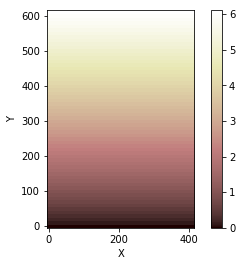

In [16]:
%matplotlib inline
from landlab.plot import imshow_grid
imshow_grid(rg, 'topographic__elevation')

The steady solution should be as follows. The unit discharge at the bottom edge should equal the precipitation rate, 100 mm/hr, times the slope length.

The slope length is the distance from the bottom edge of the bottom-most row of cells, to the top edge of the top-most row of cells. The base row of nodes are at y = 0, and the cell edges start half a cell width up from that, so y = 5 m. The top of the upper-most row of cells is half a cell width below the top grid edge, which is 610 m, so the top of the cells is 605 m. Hence the interior (cell) portion of the grid is 600 m long.

Hence, discharge out the bottom should be 100 mm/hr x 600 m = 0.1 m/hr x 600 m = 60 m2/hr. Let's convert this to m2/s:

In [17]:
q_out = 0.1 * 600 / 3600.0
q_out

0.016666666666666666

The water depth should be just sufficient to carry this discharge with the given slope and roughness. We get this by inverting the Manning equation:

$$q = (1/n) H^{5/3} S^{1/2}$$

$$H^{5/3} = n q S^{-1/2}$$

$$H = (n q)^{3/5} S^{-3/10}$$

The slope gradient is 0.01 (because we set elevation to be 0.01 times the y coordinate). The discharge, as we've already established, is about 0.0167 m2/s, and the roughness is 0.01 (the default value). Therefore,

In [18]:
n = 0.01
q = 0.0167
S = 0.01
H_out = (n * q)**0.6 * S**-0.3
H_out

0.021559063053142917

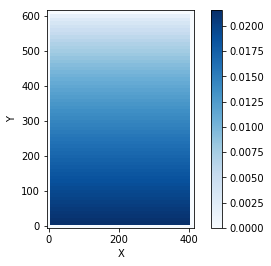

In [19]:
imshow_grid(rg, 'surface_water__depth', cmap='Blues')

This looks pretty good. Let's check the values:

In [20]:
rg.at_node['surface_water__depth'][42:84] # bottom row of core nodes

array([ 0.       ,  0.0215334,  0.0215334,  0.0215334,  0.0215334,
        0.0215334,  0.0215334,  0.0215334,  0.0215334,  0.0215334,
        0.0215334,  0.0215334,  0.0215334,  0.0215334,  0.0215334,
        0.0215334,  0.0215334,  0.0215334,  0.0215334,  0.0215334,
        0.0215334,  0.0215334,  0.0215334,  0.0215334,  0.0215334,
        0.0215334,  0.0215334,  0.0215334,  0.0215334,  0.0215334,
        0.0215334,  0.0215334,  0.0215334,  0.0215334,  0.0215334,
        0.0215334,  0.0215334,  0.0215334,  0.0215334,  0.0215334,
        0.0215334,  0.       ])

We see that the depth agrees with the analytical solution to within three decimal places: not bad. Ideally, we would build the above tests into the component as doctests or unit tests. We could also test the transient solutions: rising hydrograph, falling hydrograph. Finally, we haven't tested all the ingredients; for example, we haven't tested what happens when infiltration rate is greater than zero.

Nonetheless, the above example illustrates the basics of component-making. A great next step would be to create a unit test based on this example.

### Click here for more <a href="https://github.com/landlab/landlab/wiki/Tutorials">Landlab tutorials</a>